## 12-1. 프로젝트: 뉴스기사 요약해보기

In [53]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas
from bs4 import BeautifulSoup 

print(nltk.__version__)
print(tensorflow.__version__)
print(pandas.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [54]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Step 1. 데이터 수집하기

In [55]:
import urllib.request
import pandas as pd

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [56]:
data.sample(10)

,headlines,text
66543,Need lithium-ion battery plants for electric c...,NITI Aayog member VK Saraswat has said that In...
42725,17 Russians photographed voting multiple times...,At least 17 people were photographed by Reuter...
13154,Shivpal Singh Yadav shifts to bungalow vacated...,"The founder of Samajwadi Secular Morcha, Shivp..."
35029,What data does Facebook collect when people ar...,"Following CEO Mark Zuckerberg's testimony, Fac..."
13063,Tata Group in talks to buy stake in Jet Airway...,Tata Group has held preliminary talks to buy a...
46931,Wish to remain a Muslim: Hadiya from Kerala lo...,After her marriage was annulled by the Kerala ...
78446,"I love making love not seeing it, jokes Shah R...","Actor Shah Rukh Khan, while speaking about wor..."
67967,South Africa may host cricket's 1st 4-day Test...,South Africa could host cricket's first ever f...
70851,Ram Rahim is a sex addict: Doctor who examined...,Rape convict Gurmeet Ram Rahim Singh is a sex ...
11972,I was rejected by a director for 'looking too ...,Actress Swara Bhasker has revealed that when s...


### Step 2. 데이터 전처리하기 (추상적 요약)

In [57]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [58]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [59]:
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s))
print("Summary 전처리 후 결과: ", clean_headlines[:5])

Summary 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


In [60]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [61]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [62]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [63]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


### 훈련 데이터와 테스트 데이터 나누기
sample 회대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09983638377659
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.135964065405839


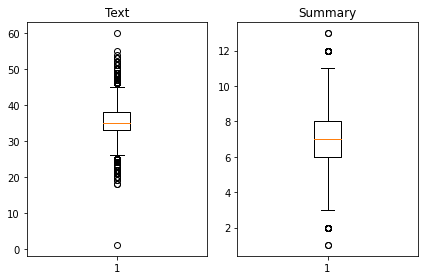

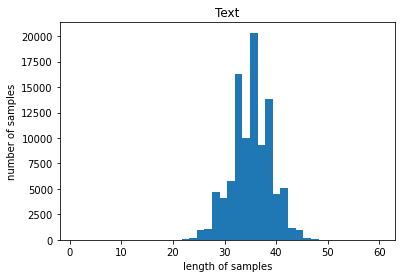

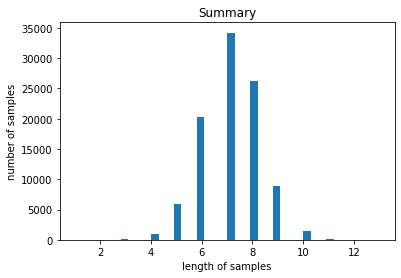

In [64]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [65]:
text_max_len = 48
text_min_len = 25

headlines_max_len = 10
headlines_min_len = 5

In [66]:
def below_threshold_len(max_len, min_len, nested_list):
    cnt = 0
    for s in nested_list:
        #if(len(s.split()) <= max_len):
        if not (len(s.split()) <= max_len and len(s.split()) >= min_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하 %s 이상이 아닌 샘플의 비율: %s'%(max_len, min_len, (cnt / len(nested_list))))

In [67]:
below_threshold_len(text_max_len, text_min_len, data['text'])
below_threshold_len(headlines_max_len,  headlines_min_len, data['headlines'])

전체 샘플 중 길이가 48 이하 25 이상이 아닌 샘플의 비율: 0.002794687045863355
전체 샘플 중 길이가 10 이하 5 이상이 아닌 샘플의 비율: 0.014197010192985844


In [68]:
original_data = data.copy() # 이후 data 조작 중 잘못됐을때 사용하기 위해 복사
data = data[data.apply(lambda x: len(x['text'].split()) <= text_max_len and len(x['headlines'].split()) <= headlines_max_len , axis=1)]
data = data[data.apply(lambda x: len(x['text'].split()) >= text_min_len and len(x['headlines'].split()) >= headlines_min_len , axis=1)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96764


### 시작 토큰과 종료 토큰 추가하기

In [69]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [70]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [71]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[93662 73827 90953 ... 79423 76761 18010]


In [72]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [73]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19352


In [74]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77412
훈련 레이블의 개수 : 77412
테스트 데이터의 개수 : 19352
테스트 레이블의 개수 : 19352


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [75]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [76]:
threshold = 7 # 등장 빈도수의 th
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69112
등장 빈도가 6번 이하인 희귀 단어의 수: 47122
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21990
단어 집합에서 희귀 단어의 비율: 68.18208125940502
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.518904569405623


In [77]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [78]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1239, 241, 4566, 82, 5893, 1421, 4726, 2698, 59, 1216, 248, 226, 2629, 5333, 2091, 1138, 431, 4933, 1675, 521, 884, 1193, 80, 198, 1726, 170, 1138, 471, 6245, 1334, 245, 1], [35, 542, 16, 177, 132, 6733, 6571, 2603, 335, 1886, 199, 2388, 4886, 1134, 261, 2875, 263, 2292, 8, 637, 785, 283, 2129, 2388, 1, 4412, 1139, 2721], [1036, 1194, 248, 377, 454, 83, 3051, 1654, 63, 264, 454, 6, 3051, 157, 1791, 2362, 77, 1066, 280, 571, 1519, 254]]


In [79]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [80]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29750
등장 빈도가 5번 이하인 희귀 단어의 수: 19511
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10239
단어 집합에서 희귀 단어의 비율: 65.58319327731093
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.882315734878337


In [81]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1316, 576, 1750, 57, 84, 600, 1896], [1, 45, 158, 99], [1, 489, 553], [1, 435, 1682, 855, 703], [1, 223, 1059]]
target
decoder  [[1316, 576, 1750, 57, 84, 600, 1896, 2], [45, 158, 99, 2], [489, 553, 2], [435, 1682, 855, 703, 2], [223, 1059, 2]]


In [82]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 193
삭제할 테스트 데이터의 개수 : 54
훈련 데이터의 개수 : 77219
훈련 레이블의 개수 : 77219
테스트 데이터의 개수 : 19298
테스트 레이블의 개수 : 19298


### 패딩하기

In [83]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

### 모델 설계하기

In [84]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

### 디코더 설계

In [85]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

어텐션 메커니즘

In [86]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 48, 128)      1024000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 48, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [87]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 조기 종료 # patience : 검증 데이터의 손실이 줄어들지 않고 증가하는 현상

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
302/302 [==============================] - 27s 72ms/step - loss: 3.6360 - val_loss: 3.3599
Epoch 2/50
302/302 [==============================] - 21s 69ms/step - loss: 3.1863 - val_loss: 3.0244
Epoch 3/50
302/302 [==============================] - 21s 70ms/step - loss: 2.9161 - val_loss: 2.8164
Epoch 4/50
302/302 [==============================] - 22s 71ms/step - loss: 2.7328 - val_loss: 2.7054
Epoch 5/50
302/302 [==============================] - 22s 72ms/step - loss: 2.5981 - val_loss: 2.5986
Epoch 6/50
302/302 [==============================] - 22s 72ms/step - loss: 2.4866 - val_loss: 2.5161
Epoch 7/50
302/302 [==============================] - 22s 72ms/step - loss: 2.3895 - val_loss: 2.4528
Epoch 8/50
302/302 [==============================] - 22s 72ms/step - loss: 2.3036 - val_loss: 2.4049
Epoch 9/50
302/302 [==============================] - 22s 72ms/step - loss: 2.2272 - val_loss: 2.3543
Epoch 10/50
302/302 [==============================] - 22s 72ms/step - loss: 2.159

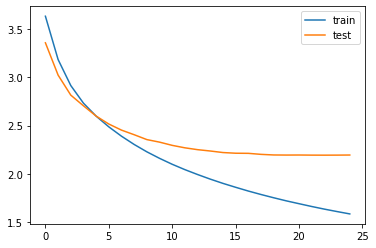

In [88]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [89]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [90]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [91]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [92]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [93]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            if tar_index_to_word[i] == 'sostoken' or tar_index_to_word[i] == 'eostoken':
                continue
            temp = temp + tar_index_to_word[i]+' '
    return temp

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

### 모델 테스트 하기

In [94]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : german tennis player brown hit diving widely called shot tournament wimbledon opening round match portugal monday following rally brown approached net hit winner reaching passing shot diving full stretch towards right 
실제 요약 : called shot wimbledon 
예측 요약 :  fighter fighter shot dead wimbledon


원문 : karnataka hc told woman fighting get lakh maintenance per month estranged husband enough woman reportedly claimed cost living bengaluru high ex husband well however man said unemployed found difficult make living 
실제 요약 : woman seeks lakh hc says enough 
예측 요약 :  woman treatment husband


원문 : maharashtra cabinet thursday announced crore relief farmers government also decided grant ex gratia per upper limit per farmer kitchen sold november december comes amid reports farmers selling per kg 
실제 요약 : maha cabinet approves crore relief farmers 
예측 요약 :  maharashtra govt approves crore loan


원문 : alia bhatt said would love play role goddess film made tripathi upcoming book added story ge

예측 요약 :  google invest mn app


원문 : actor prakash raj said enter politics someone challenges take late communal politics importance country must let happen added however prakash said neither political particular party 
실제 요약 : enter politics someone raj 
예측 요약 :  politics politics


원문 : bengaluru based designer accused taxi hailing startup ola using design made hoardings without permission design shows line art building bengaluru ola also accused using picture app launch screen without permission photographer 
실제 요약 : man accuses ola without 
예측 요약 :  ola driver bengaluru


원문 : actor rajinikanth announced entry politics user tweeted normal people go party new year form party new year tweet read waiting shivaji boss real world another user wrote two types people rajinikanth join politics politics join rajinikanth 
실제 요약 : nothing tweets user 
예측 요약 :  rajinikanth tweets user rajinikanth


원문 : indian football team crashed asian cup losing bahrain last group match monday bahrain jamal

### Step 5. Summa을 이용해서 추출적 요약해보기

In [95]:
import requests
from summa.summarizer import summarize

In [96]:
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 : ", seq2summary(decoder_input_test[i]))
    print("추상적 예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출적 예측 요약 :", summarize(seq2text(encoder_input_test[i]), ratio=0.5))
#     print("예측 요약 :", summarize(seq2text(encoder_input_test[i]), words=50))
    print("\n")

원문 : german tennis player brown hit diving widely called shot tournament wimbledon opening round match portugal monday following rally brown approached net hit winner reaching passing shot diving full stretch towards right 
실제 요약 :  called shot wimbledon 
추상적 예측 요약 :  fighter fighter shot dead wimbledon
추출적 예측 요약 : 


원문 : karnataka hc told woman fighting get lakh maintenance per month estranged husband enough woman reportedly claimed cost living bengaluru high ex husband well however man said unemployed found difficult make living 
실제 요약 :  woman seeks lakh hc says enough 
추상적 예측 요약 :  woman treatment husband
추출적 예측 요약 : 


원문 : maharashtra cabinet thursday announced crore relief farmers government also decided grant ex gratia per upper limit per farmer kitchen sold november december comes amid reports farmers selling per kg 
실제 요약 :  maha cabinet approves crore relief farmers 
추상적 예측 요약 :  maharashtra govt approves crore loan
추출적 예측 요약 : 


원문 : alia bhatt said would love play role g

In [97]:
data_org = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
for i in range(50, 100):
#     _text = seq2text(encoder_input_test[i])
    _text = data_org.iloc[i,1]
    print("원문 :", _text)
    print("실제 요약 : ", data_org.iloc[i,0])
    print("예측 요약 : ", summarize(_text, ratio=0.35)) # ratio안달면 결과 안나옴...
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 :  Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 :  Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straig

In [98]:
data_org = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
for i in range(50, 100):
    print("원문 :", data_org['text'][i] )
    print('\n')
    print("추출 요약 :", summarize(data_org['text'][i], ratio=0.5) )
    print("실제 요약 :", data_org['headlines'][i] )
    print('\n')
    print("-------------------------------------------------------")
    print('\n')

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.


추출 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL


-------------------------------------------------------


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its positio

## Abstract Summarization vs Extractive Summarization


Text Min 값 : 30
Text Max 값 : 40 
Summary Min : 6
Summary Max : 8
ratio=0.35

#### Abstract Summarization: 
실제 요약의 Keyword들이 포함되었으나 아닌 경우도 다수 있었고 없는 단어인 것들도 많았습니다. 아예 존재하지 않는 단어들도 많이 예측되었기때문에 문법적으로는 거의 맞다 안맞다를 평가할 수준은 아니었습니다. 

##### Extractive Summarization
대비 비교적 Keyword들이 많이 포함 되어 있고 좀 더 긴 문장을 예측하나 예측 문장을 아예 만들지 못하는 경우도 다수 있었습니다. 문법적으로도 어느정도 맞는 문장을 출력합니다. 문장이 길어지도 문법적으로 향상되었으나, 결과값을 아예 출력못하는 경우는 틀린답이라도 내는 Abstract Summarization보다 성능측면에서는 떨어지는 면도 있다고 생각합니다. 서비스를 받는 입장에서 먹통인 상황과 틀린 문장이라도 보여주는 차이 정도일것 같습니다. 

전반적으로 결과의 정확도 면에서는 Extractive Summarization가 성능이 더 좋다고 판단되나 예측을 할 수 없는 빈도가 높다는 것은 결정적인 단점이라고 생각합니다. 

Text Min 값 : 30
Text Max 값 : 40 
Summary Min : 6
Summary Max : 8
ratio=0.35

좀 더 성능을 높이기 위해 Min/Max 값의 폭을 넓혀서 다시 모델이 하였고, 상기 값들에 대한 예측결과는 Abstract Summarization의 경우는 큰 차이가 없었고, Extractive Summarization는 조금 더 정확한 문장을 만든다는것을 확있했습니다. 

Text Min 값 : 25
Text Max 값 : 48 
Summary Min : 5
Summary Max : 10
ratio=0.5

보다 성능을 개선하기 위해 ratio=0.5로 올려 test을 진행했하였고, Extractive Summarization의 경우 0.35일때보다 성능이 향상되는것을 확인할 수 있었습니다.

####  느낀점
팀원인 소용현님의 조언으로 min,max 값 조정하는 issue에 대해 이야기를 나누었고, 값을 선정하는 기준과 방식에 대해 이야기를 나누었고, 경험과 자기만의 논리를 가지고 기준을 만들어 갈 수 밖에 없다는 부분에 공감하였습니다. 
